# Grayscale 3D CNN

In [1]:
#%%python3 -m pip install --upgrade pip


In [1]:
#%pip install tensorflow_docs --upgrade
%pip install mediapipe=='0.10.9'
%pip install opencv-python=='4.8.0.76'

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from train_utils import display_frames

from train_utils import VideoDatasetBig

2024-03-06 21:57:46.126455: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-06 21:57:47.211091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-06 21:57:50.204632: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change 

In [3]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 124

limit_list = []

annotations_file = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv" # "/content/drive/MyDrive/slovo/SLOVO_DATAFRAME.tsv" #
video_dir = "/home/jupyter/mnt/s3/rsl-videos/slovo/slovo" #"/content/drive/MyDrive/slovo/slovo" #

face_detection_model = 'face_detection_yunet_2023mar.onnx'


In [4]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
max_frame_count = max(video_labels['end']-video_labels['begin']+1)
print(max_frame_count)
max_frame_count = min(max_frame_count,50)
print(max_frame_count)

233
50


In [5]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 1000. Example classes: ('Ё', 'А', 'Р', 'Е', 'Ч')


In [6]:
train_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
test_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
val_kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

In [7]:
test_dataloader = DataLoader(VideoDatasetBig(video_labels.tail(2), video_dir, IMG_SIZE, max_frame_count, classes, face_detection_model, ds_type = "test"), batch_size=test_batch_size, shuffle=True, **test_kwargs)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
frames, labels = next(iter(test_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
# frames = frames.permute(0,2,1,3,4) # (B, T, C, H, W) for swin
# print(f"Frames shape: {frames.shape}") #
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 50, 124, 124])
Labels shape: torch.Size([1])
Labels: tensor([878])


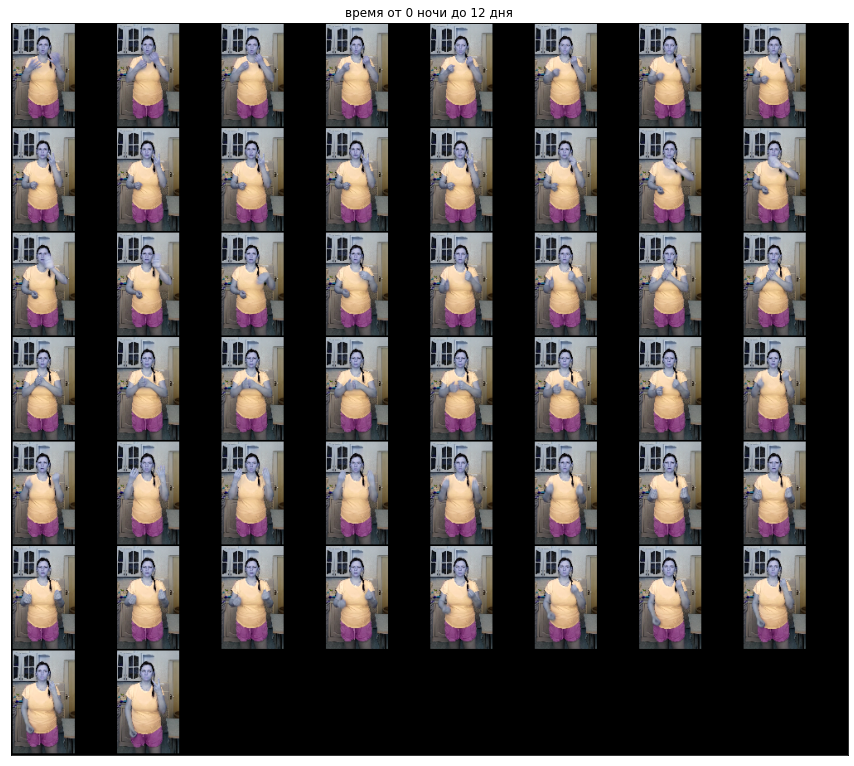

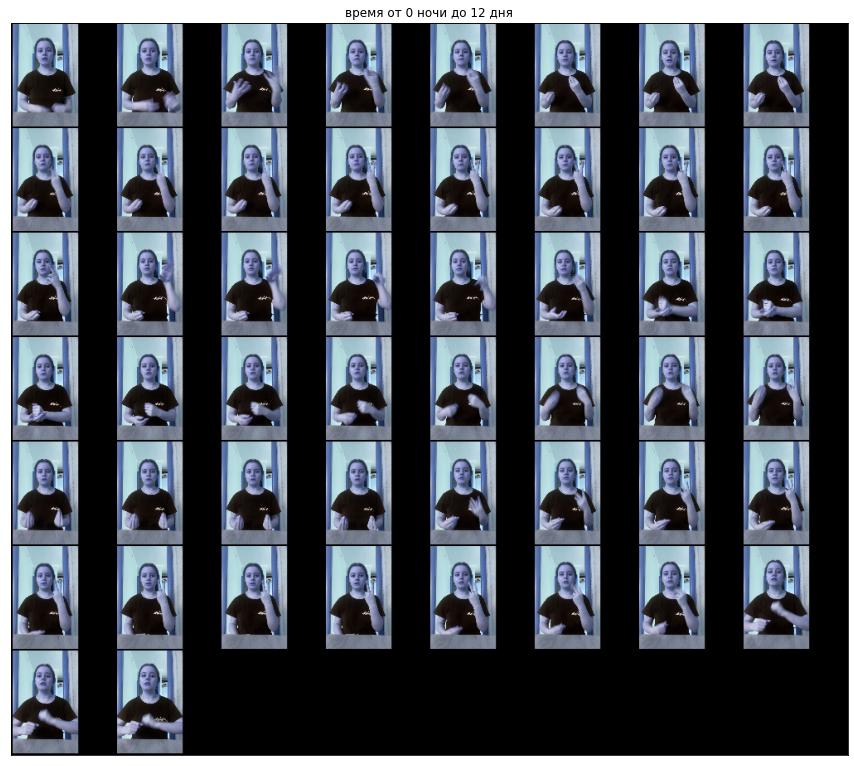

In [9]:
display_frames(n_frames=2, dataloader=test_dataloader, classes=classes)

In [10]:
len(video_labels)

20000

In [ ]:
test_dataloader = DataLoader(VideoDatasetBig(video_labels, video_dir, IMG_SIZE, max_frame_count, classes, face_detection_model, ds_type = "test"), batch_size=test_batch_size, shuffle=True, **test_kwargs)
torch.save(test_dataloader, 'color_frames_50_test_dataloader.pth')

In [ ]:
test_dataloader=None

In [ ]:
val_dataloader = DataLoader(VideoDatasetBig(video_labels, video_dir, IMG_SIZE, max_frame_count, classes, face_detection_model, ds_type = "val"), batch_size=val_batch_size, shuffle=True, **val_kwargs)
torch.save(val_dataloader, 'color_frames_50_val_dataloader.pth')#

In [ ]:
val_dataloader=None

In [ ]:
train_dataloader = DataLoader(VideoDatasetBig(video_labels, video_dir, IMG_SIZE, max_frame_count, classes, face_detection_model, ds_type = "train"), batch_size=train_batch_size, shuffle=True, **train_kwargs)
torch.save(train_dataloader, 'color_frames_50_train_dataloader.pth')

In [ ]:
train_dataloader=None

In [ ]:
print(2)